# RipsNet with Torch

In [4]:
from src.arxiv.dataset import create_multiple_circles
from src.model.components import DenseNestedTensors, PermopNestedTensors


import gudhi as gd
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from gudhi.representations import DiagramSelector
from gudhi.representations import Landscape, PersistenceImage

# Dataset
In this tutorial, we show how to use RipsNet to learn the topology of very simple synthetic data sets comprised of (noisy) circles. Let's first define the seed (for reproducibility), the number of point clouds that we will use for training RipsNet, the number of point clouds we will use to test it, the cardinality of the point clouds and finally the amount of corrupted points (when noise is added).

In [5]:
N_sets_train = 900  # Number of train point clouds
N_sets_test = 300  # Number of test  point clouds
N_points = 600  # Point cloud cardinality
N_noise = 200  # Number of corrupted points

In [6]:
data_train, label_train = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise)
clean_data_test, clean_label_test = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise)
noisy_data_test, noisy_label_test = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

100%|██████████| 100/100 [00:00<00:00, 132.95it/s]


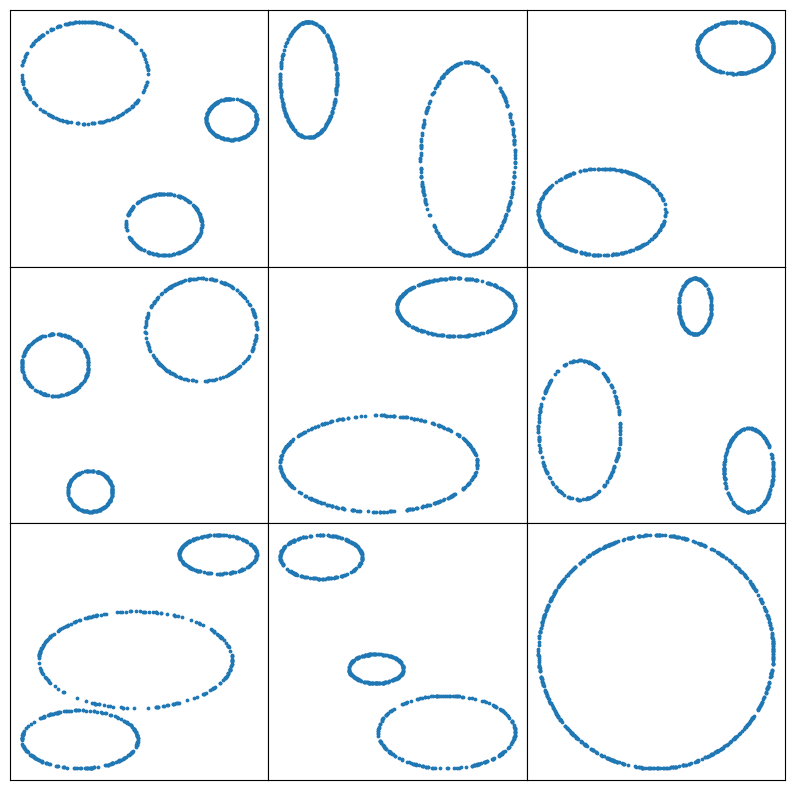

In [7]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

As one can see, they contain 1 to 3 circular shapes. We will use these circle numbers later for checking the accuracy of the topology computed by RipsNet. For now, let's save them as proper labels.

In [8]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

In order to train RipsNet, we need the correct topology on the train data. So let's compute it with [Gudhi](https://gudhi.inria.fr/python/latest/). The topology of point clouds can be inferred from several filtrations, so we will use a fast and sparse one (in 2D), namely the [Alpha filtration](https://gudhi.inria.fr/python/latest/alpha_complex_user.html). First, we need to get a sense of the maximal filtration value to use, which we will approximate with the largest pairwise distance of the first 30 point clouds.

In [9]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

In [10]:
# train PD
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

# test PD
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)


# noisy PD
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|██████████| 300/300 [00:02<00:00, 128.73it/s]


RipsNet actually works on vectorizations of persistence diagrams (PDs), so we will try two: the [persistence image](https://jmlr.org/papers/volume18/16-337/16-337.pdf), and the [persistence landscape](https://jmlr.csail.mit.edu/papers/volume16/bubenik15a/bubenik15a.pdf). First, let's filter out any PD point with infinite coordinates.

In [11]:
PVs_train, clean_PVs_test, noisy_PVs_test, PVs_params = [], [], [], []
pds_train = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

TP_train = [(pd[:,1] - pd[:,0]).sum() for pd in pds_train]
TP_clean_test = [(pd[:,1] - pd[:,0]).sum() for pd in clean_pds_test]
TP_noisy_test = [(pd[:,1] - pd[:,0]).sum() for pd in noisy_pds_test]

Fortunately, Gudhi also has code for computing vectorizations!! However, before launching the computations, we have to estimate a few parameters: the image bandwidth (taken as the 20% quantile of the positive birth-persistence-transformed-PD pairwise distances),
and the image and landscape limits (taken as the min and max of birth-persistence-transformed-PD point coordinates). 

In [12]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

In [13]:
### Persistence Images
PI_params = {'bandwidth': sigma, 
             'weight': lambda x: 10*np.tanh(x[1]), 
             'resolution': [50,50], 
             'im_range': im_bnds
             }
PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
clean_PI_test = PersistenceImage(**PI_params).fit_transform(clean_pds_test)
noisy_PI_test = PersistenceImage(**PI_params).fit_transform(noisy_pds_test)
MPI = np.max(PI_train)
PI_train /= MPI
clean_PI_test /= MPI
noisy_PI_test /= MPI

In [14]:
### Persistence Landscapes
PL_params = {'num_landscapes': 5, 'resolution': 300, 'sample_range': sp_bnds}
PL_train = Landscape(**PL_params).fit_transform(pds_train)
clean_PL_test = Landscape(**PL_params).fit_transform(clean_pds_test)
noisy_PL_test = Landscape(**PL_params).fit_transform(noisy_pds_test)
MPL = np.max(PL_train)
PL_train /= MPL
clean_PL_test /= MPL
noisy_PL_test /= MPL

# Training RipsNet on PI

In [15]:
data_train

[array([[-4.64493716, -7.97298982],
        [10.85840142,  9.77571018],
        [-4.81003142, -8.37053191],
        ...,
        [12.26209827, 12.95594497],
        [-3.805413  ,  9.78621318],
        [-9.1537727 , -9.52112556]]),
 array([[-3.91143624, -7.49805112],
        [15.18413782, -3.70269012],
        [10.40629978,  3.2636943 ],
        ...,
        [14.9174822 , -3.71420068],
        [-8.41985798,  1.42299106],
        [-2.55250365, -6.56049436]]),
 array([[ 0.35553373, -4.22765601],
        [-3.30079217, -3.31945282],
        [ 0.34548383, -4.24264459],
        ...,
        [ 0.68751659, -3.03520712],
        [ 0.68060005, -3.30847195],
        [-2.46037417, -4.75783718]]),
 array([[-13.29360607, -14.74622865],
        [ -9.52643431, -10.85201161],
        [ -3.43394947, -11.12260762],
        ...,
        [ -4.07749828, -10.46286756],
        [  1.20844698,  -9.6831019 ],
        [-19.42668892, -10.07203564]]),
 array([[ 13.60709044,  13.83066812],
        [  6.62813704,  10

In [ ]:
X_train = torch.nested.nested_tensor(data_train, dtype=torch.float32)
X_val = torch.nested.nested_tensor(clean_data_test, dtype=torch.float32)
X_test = torch.nested.nested_tensor(noisy_data_test, dtype=torch.float32)

# PI_train = torch.from_numpy(PI_train).float()
# PI_val = torch.from_numpy(clean_PI_test).float()

# print(len(X_train), len(X_val), len(X_test))

RuntimeError: Internal error: NestedTensorImpl doesn't support sizes. Please file an issue.

### model

In [13]:
ripsnet = nn.Sequential(
    DenseNestedTensors(30, last_dim=2, use_bias=True),
    DenseNestedTensors(20, last_dim=30, use_bias=True),
    DenseNestedTensors(10, last_dim=20,use_bias=True),
    PermopNestedTensors(),
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Linear(200, PI_train.shape[1]),
    nn.Sigmoid()
    )
optim = torch.optim.Adam(ripsnet.parameters(), lr=5e-4)
loss = nn.MSELoss()

In [14]:
## train loop 
for epoch in range(200):
    optim.zero_grad()
    out = ripsnet(X_train)
    l = loss(out, PI_train)
    l_val =  loss(ripsnet(X_val), PI_val)
    l.backward()
    optim.step()
    print(f"Epoch {epoch} - Loss: {l.item()} - Val Loss: {l_val.item()}")

Epoch 0 - Loss: 0.38841912150382996 - Val Loss: 0.3873465955257416
Epoch 1 - Loss: 0.3470044732093811 - Val Loss: 0.34610551595687866
Epoch 2 - Loss: 0.30843761563301086 - Val Loss: 0.3076798617839813
Epoch 3 - Loss: 0.2727143466472626 - Val Loss: 0.2720947265625
Epoch 4 - Loss: 0.23974472284317017 - Val Loss: 0.23926585912704468
Epoch 5 - Loss: 0.20936283469200134 - Val Loss: 0.20902159810066223
Epoch 6 - Loss: 0.18146470189094543 - Val Loss: 0.1812489628791809
Epoch 7 - Loss: 0.15620967745780945 - Val Loss: 0.15611322224140167
Epoch 8 - Loss: 0.13373872637748718 - Val Loss: 0.13378220796585083
Epoch 9 - Loss: 0.11400296539068222 - Val Loss: 0.11418287456035614
Epoch 10 - Loss: 0.09678424894809723 - Val Loss: 0.09706118702888489
Epoch 11 - Loss: 0.08190441131591797 - Val Loss: 0.08221066743135452
Epoch 12 - Loss: 0.06903991848230362 - Val Loss: 0.06935648620128632
Epoch 13 - Loss: 0.05789865925908089 - Val Loss: 0.05820870399475098
Epoch 14 - Loss: 0.04830300807952881 - Val Loss: 0.04

### inference

In [21]:
ripsnet.eval()
with torch.no_grad():
    train_PL_prediction = ripsnet(X_train)
    val_PL_prediction = ripsnet(X_val)
    noisy_PL_prediction = ripsnet(X_test)

Let's see how accurate the predictions of RipsNet really are, at least on the **train set**.

606.8317260742188
606.8424072265625
915.81982421875
607.663818359375
915.5803833007812
305.951904296875
305.9576721191406
608.1356201171875
607.2249755859375


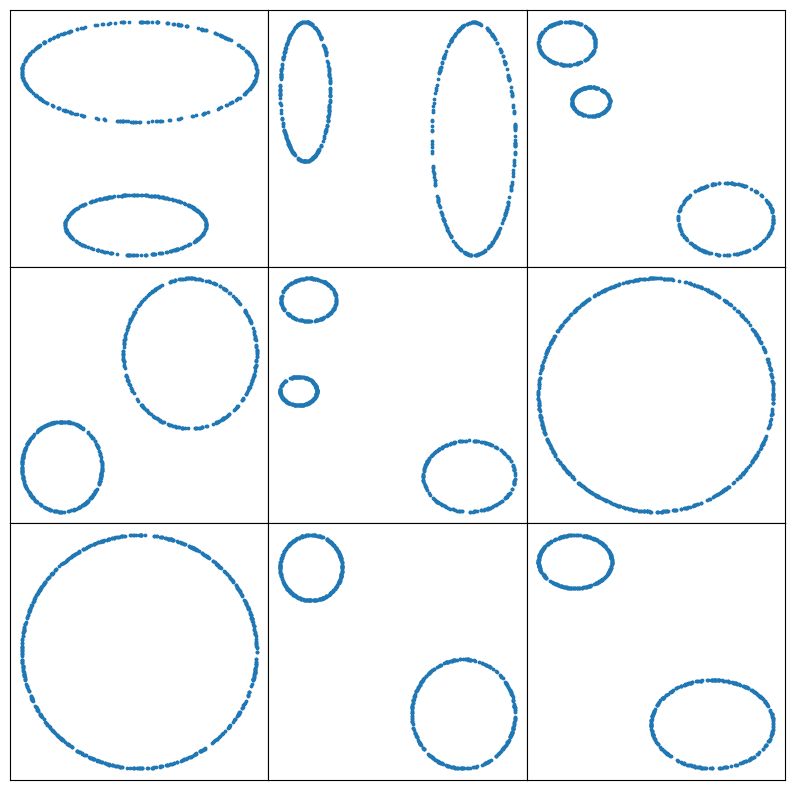

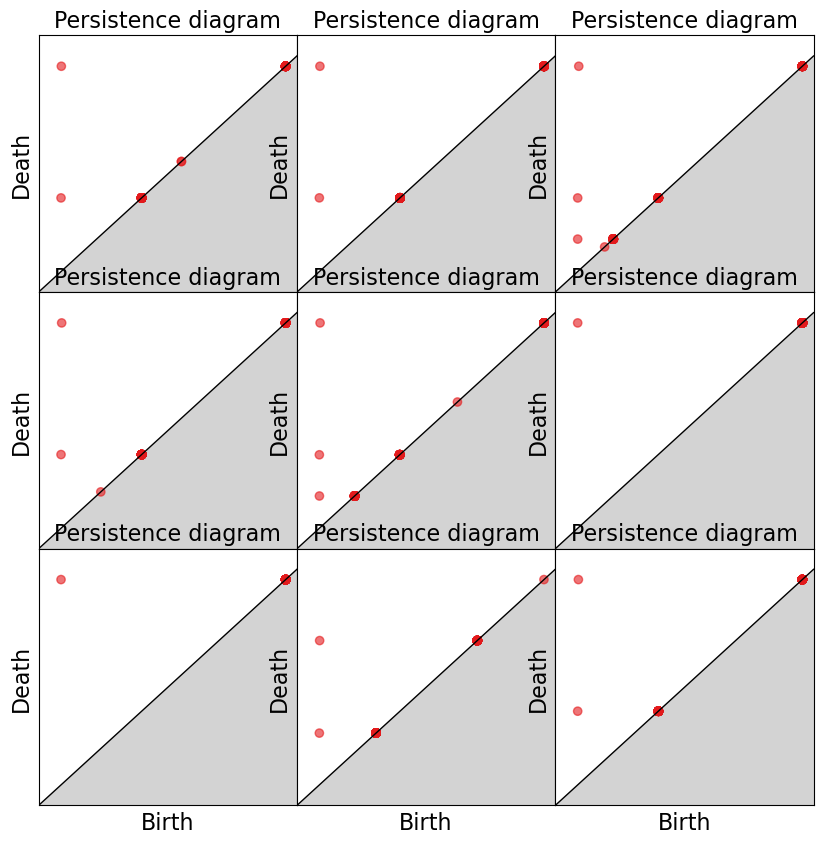

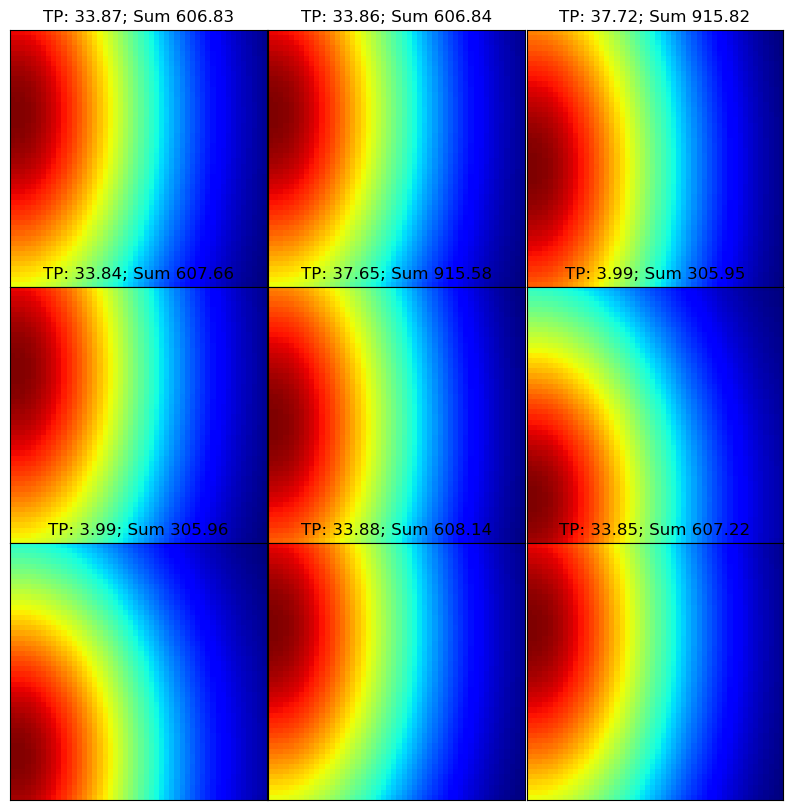

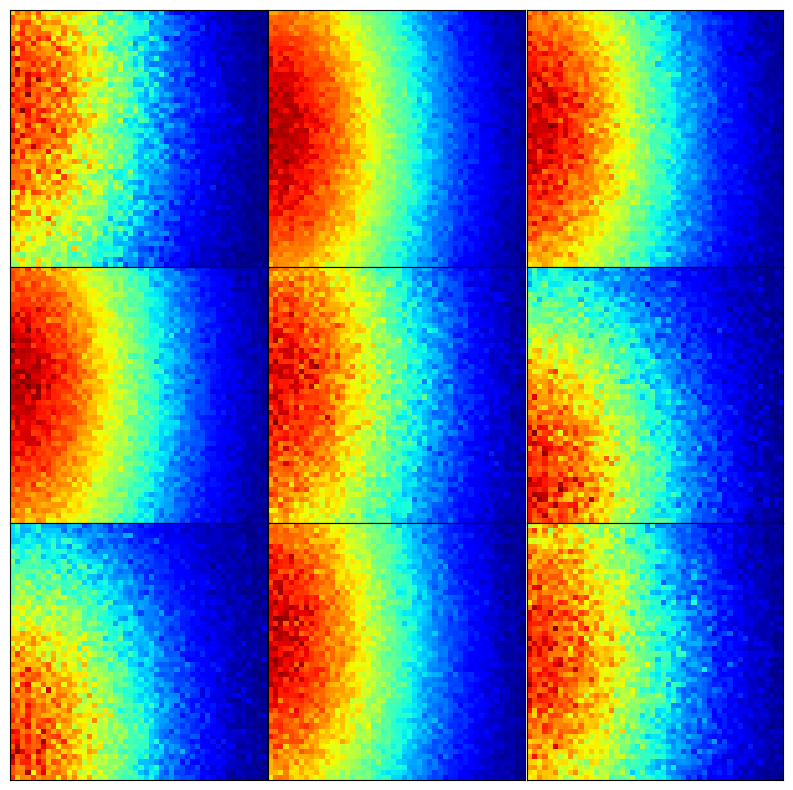

In [39]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
data_train_np = np.asarray(data_train)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(data_train_np[3*i+j,:,0], data_train_np[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

PI_train_np = PI_train.numpy()
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        gd.plot_persistence_diagram(PD_train[3*i+j], axes=ax)
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(PI_train_np[3*i+j], (50,50)), 0), cmap='jet')
        summing = float(np.sum(PI_train_np[3*i+j]))
        print(summing)
        ax.set_title('TP: {:.2f}; Sum {:.2f}'.format(TP_train[3*i+j], 
                                              summing))
        plt.xticks([])
        plt.yticks([])

train_PL_prediction_np = train_PL_prediction.numpy()
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(train_PL_prediction_np[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

Let's visualize the prediction on the test set

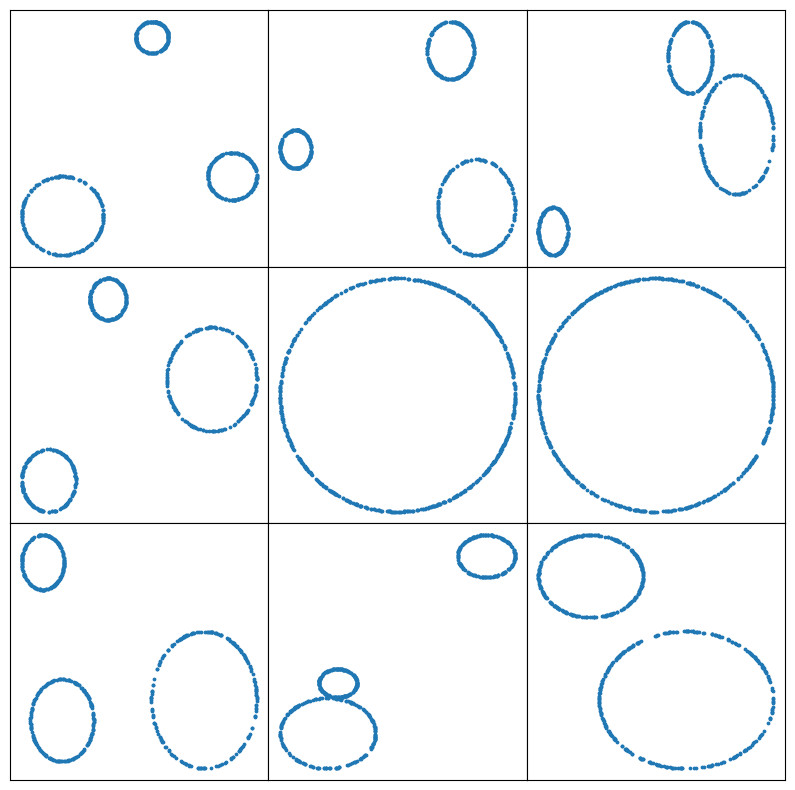

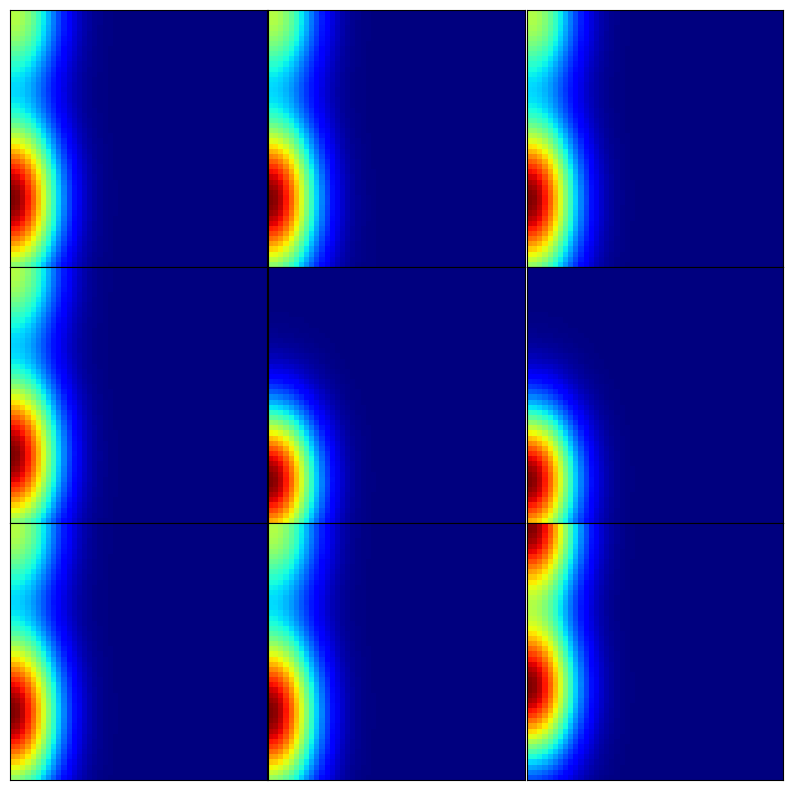

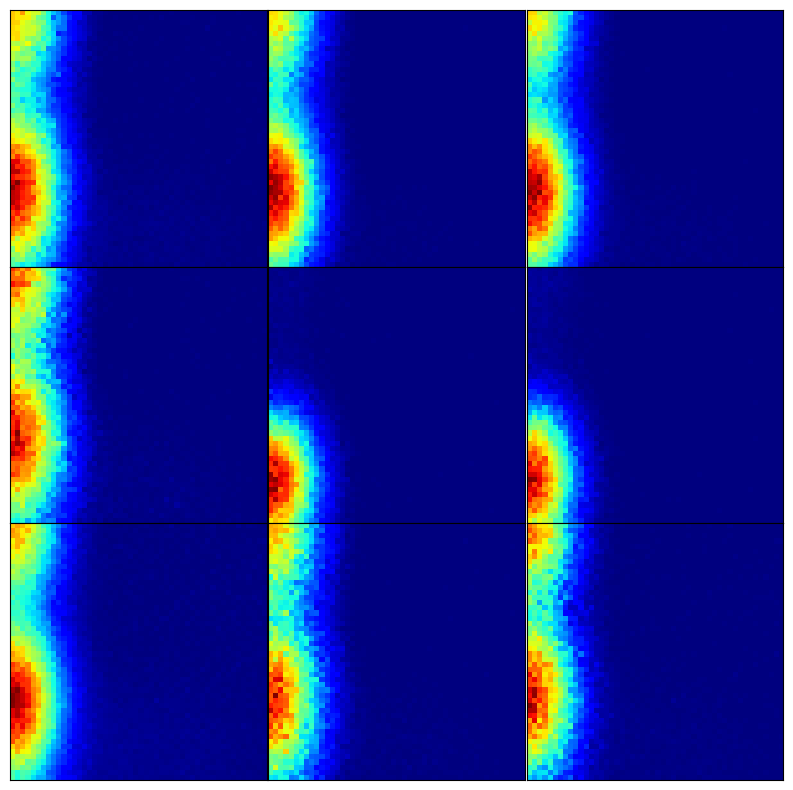

In [22]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
clean_data_test = np.asarray(clean_data_test)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j,:,0], clean_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

clean_PL_prediction_np = val_PL_prediction.numpy()
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PL_prediction_np[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

Pretty good actually! Let's look at the test set now.

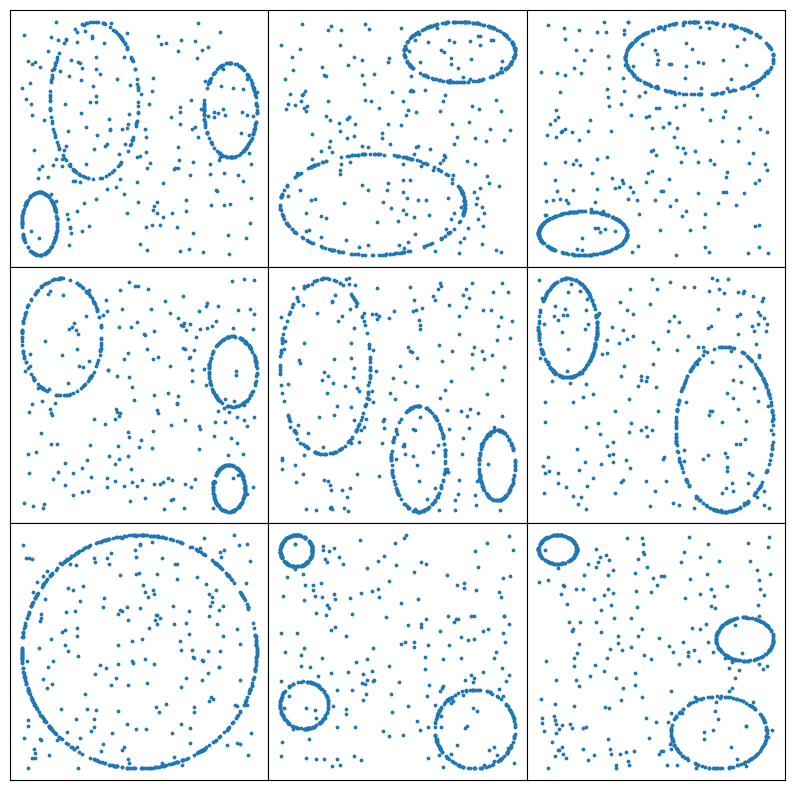

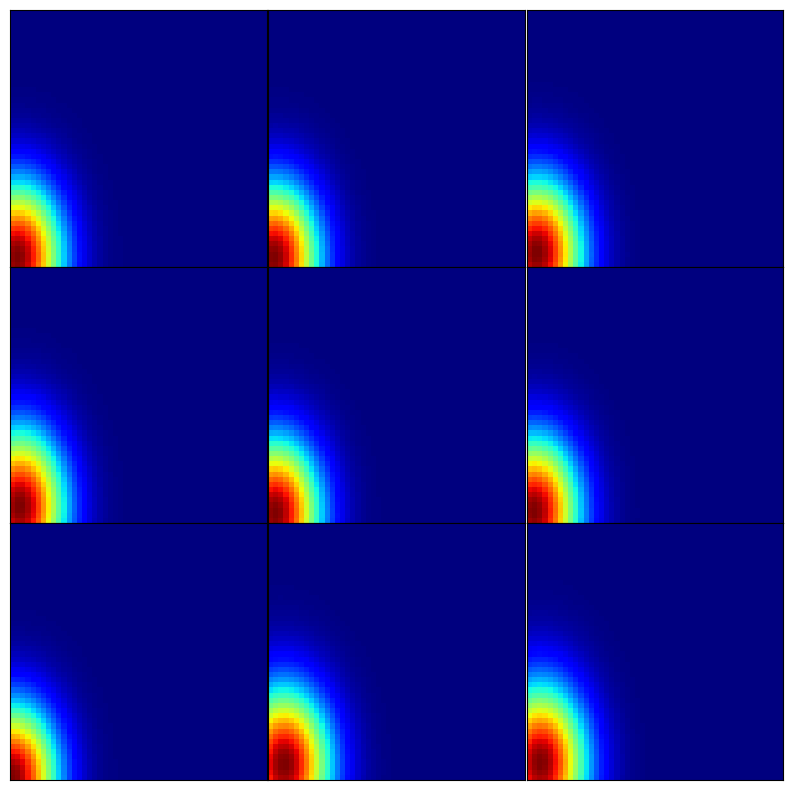

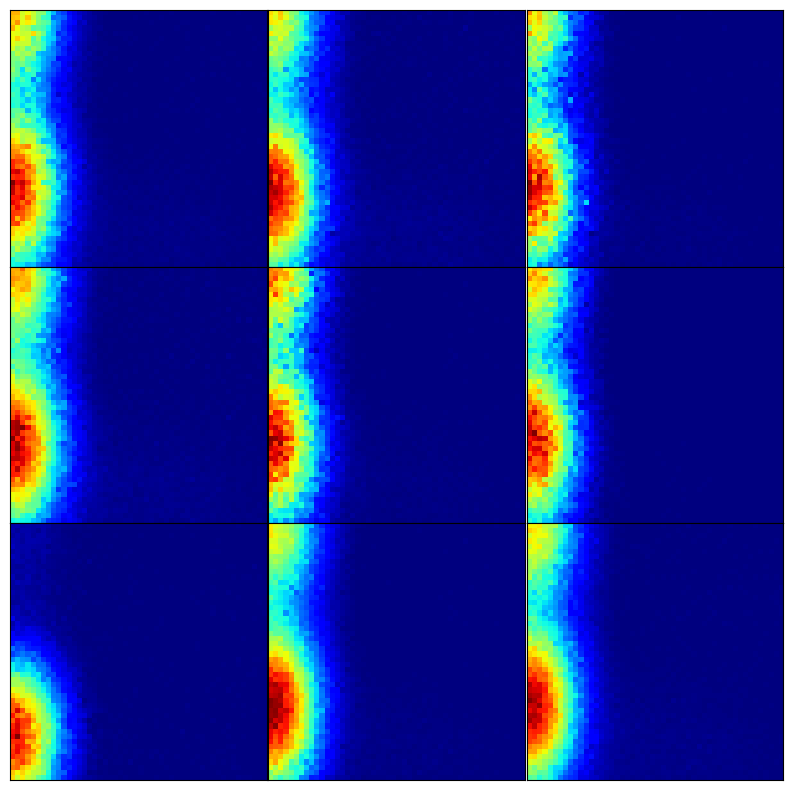

In [23]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
noisy_data_test = np.asarray(noisy_data_test)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j,:,0], noisy_data_test[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(noisy_PI_test[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])


fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
noisy_PL_prediction_np = noisy_PL_prediction.numpy()
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(noisy_PL_prediction_np[3*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()

Yep, even though Gudhi now produces bad images because of the ambiant noise, RipsNet predictions still look rather good. Another way to quantify this is to see the difference between classifiers predicting the number of circles that are trained either from Gudhi or from RipsNet predictions. Let's first see how an XGBoost model performs when using Gudhi descriptors.

In [24]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PI_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PI_test, clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PI_test, noisy_label_classif_test)

/home/jmordacq/miniconda3/envs/tda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:12:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [25]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 0.9966666666666667
Accuracy on noisy test set = 0.3333333333333333
